
🔹 **Filtering Methods:**
ANOVA: Index(['sex', 'age', 'who', 'adult_male', 'alive'], dtype='object')
Chi-Square: Index(['sex', 'who', 'adult_male', 'alive', 'alone'], dtype='object')
Information Gain: Index(['pclass', 'sex', 'who', 'adult_male', 'alive'], dtype='object')
Pearson's Correlation: ['fare', 'deck', 'alive', 'adult_male', 'sex']
Random Forest Importance: ['alive', 'adult_male', 'sex', 'fare', 'age']
Permutation Importance: ['alive', 'pclass', 'sex', 'age', 'sibsp']

🔹 **Wrapper Methods:**
Forward Selection: ['pclass', 'sex', 'age', 'sibsp', 'alive']
Backward Elimination: ['adult_male', 'deck', 'embark_town', 'alive', 'alone']
RFE: ['sex', 'age', 'who', 'adult_male', 'alive']
RFE with CV: ['alive']


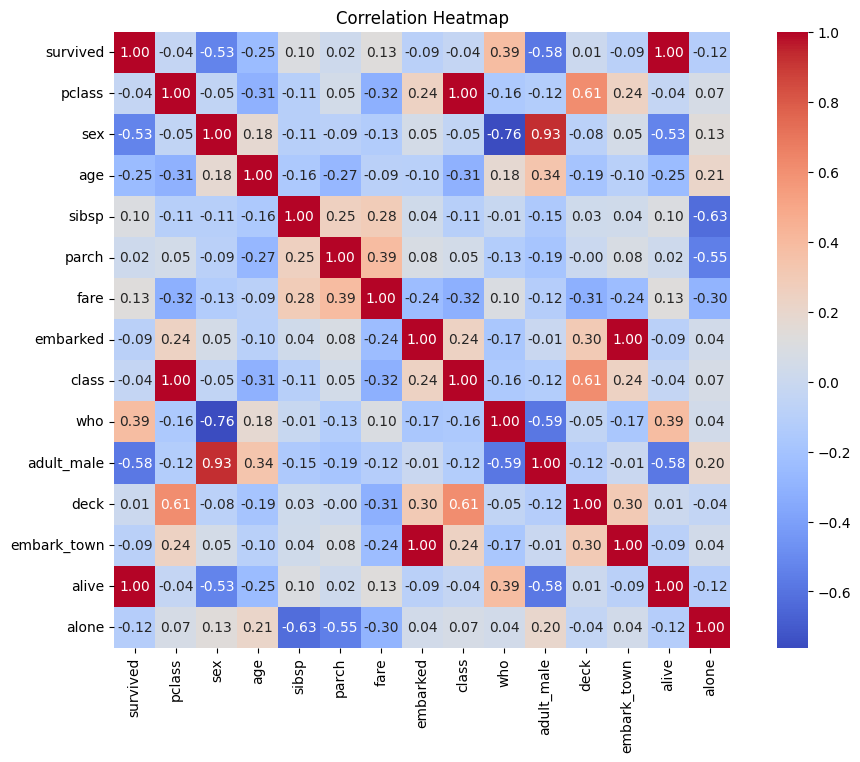

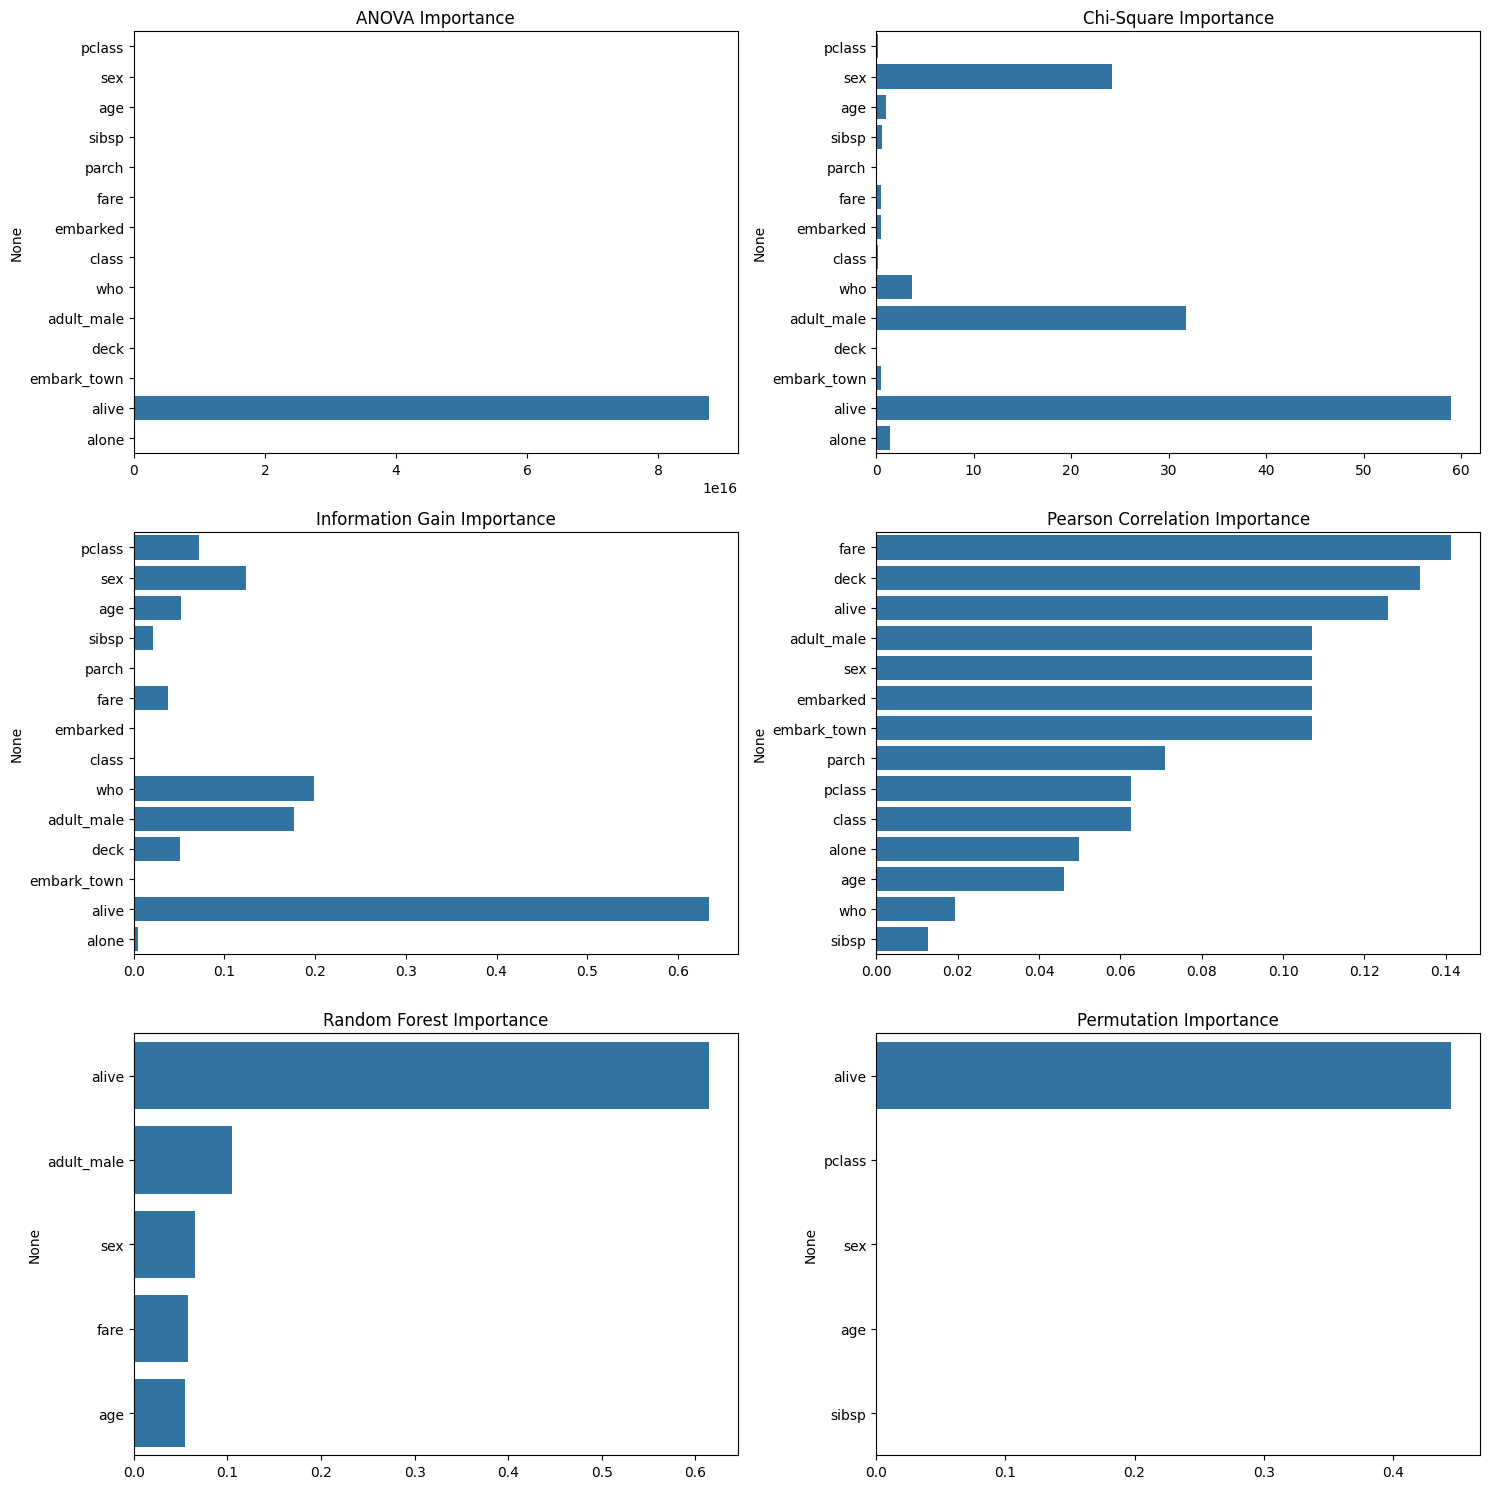

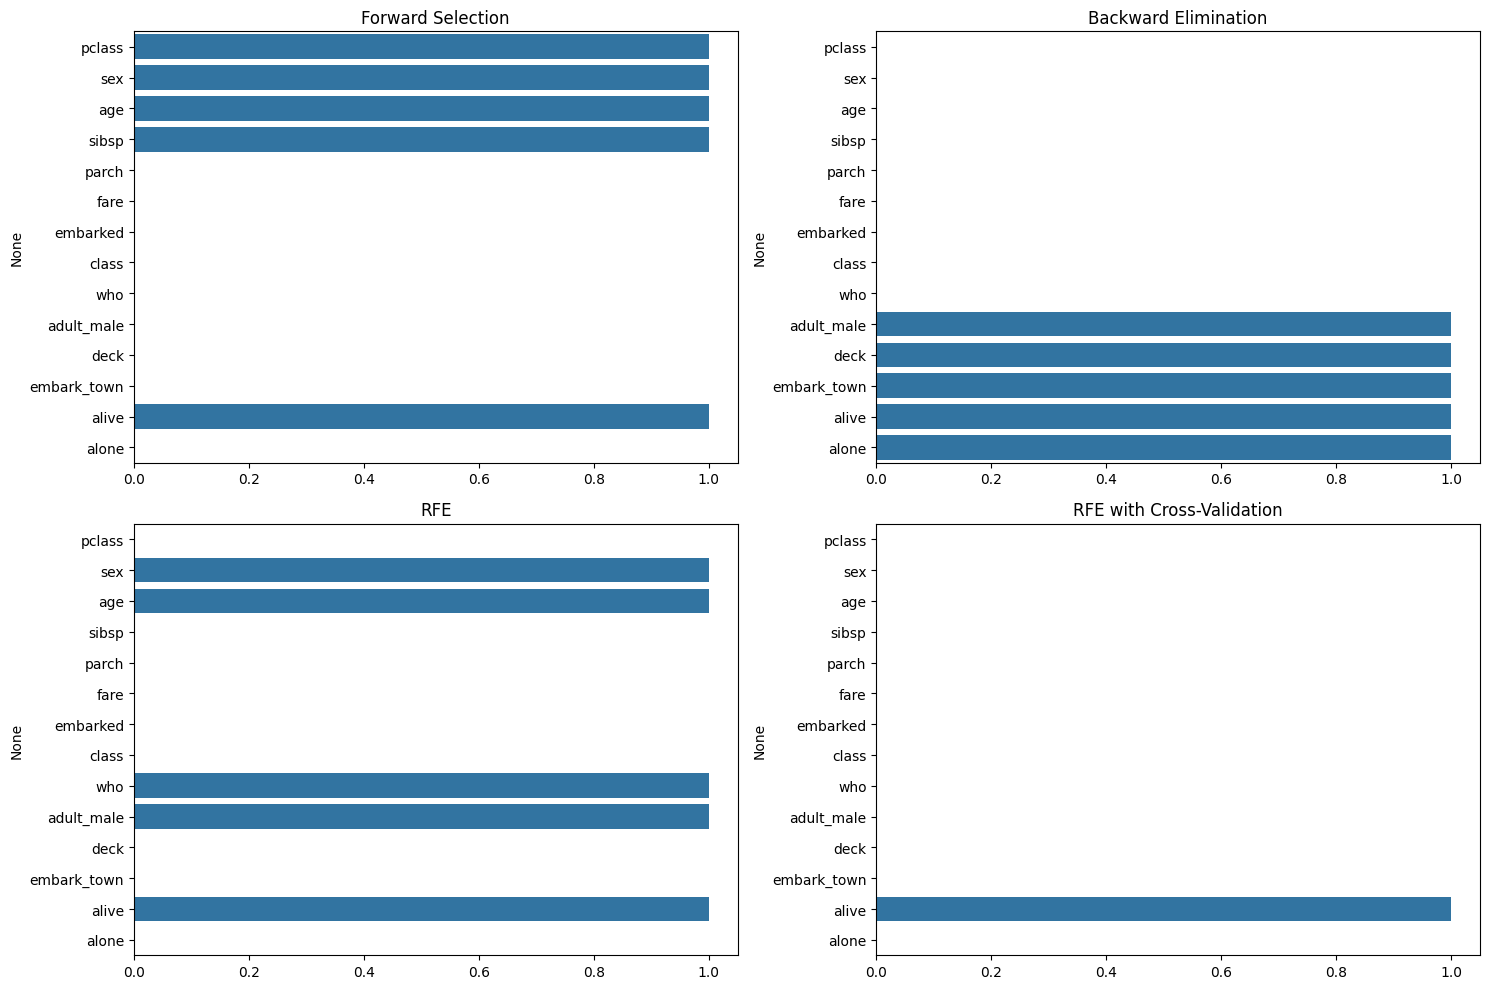

In [3]:
# Importing Libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.feature_selection import SelectKBest, f_classif, chi2, mutual_info_classif
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
from sklearn.feature_selection import SequentialFeatureSelector, RFE, RFECV
from sklearn.linear_model import LogisticRegression
import seaborn as sns
import matplotlib.pyplot as plt

# ------------------------
# 1. Load and Preprocess Dataset
# ------------------------
# Load Dataset
url = "https://raw.githubusercontent.com/mwaskom/seaborn-data/master/titanic.csv"
df = pd.read_csv(url)

# Remove Missing Values & Duplicates
df.dropna(inplace=True)
df.drop_duplicates(inplace=True)

# Encode Categorical Variables
encoder = LabelEncoder()
for col in df.select_dtypes(include='object').columns:
    df[col] = encoder.fit_transform(df[col])

# Split the Data
X = df.drop("survived", axis=1)
y = df["survived"]

# Scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# ------------------------
# 2. Filtering Methods
# ------------------------

# ANOVA (Standard Scaled Data)
anova_selector = SelectKBest(f_classif, k=5)
anova_selector.fit(X_scaled, y)
anova_features = X.columns[anova_selector.get_support()]

# Chi-Square (MinMax Scaled Data)
minmax_scaler = MinMaxScaler()
X_minmax = minmax_scaler.fit_transform(X)

chi_selector = SelectKBest(chi2, k=5)
chi_selector.fit(X_minmax, y)
chi_features = X.columns[chi_selector.get_support()]

# Information Gain
info_selector = SelectKBest(mutual_info_classif, k=5)
info_selector.fit(X_scaled, y)
info_features = X.columns[info_selector.get_support()]

# Pearson's Correlation
corr_matrix = pd.DataFrame(X_scaled, columns=X.columns).corrwith(pd.Series(y)).abs().sort_values(ascending=False)
pearson_features = corr_matrix.head(5).index.tolist()

# Random Forest Feature Importance
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_scaled, y)
rf_importances = pd.Series(rf_model.feature_importances_, index=X.columns).nlargest(5)

# Permutation Feature Importance
perm_importance = permutation_importance(rf_model, X_scaled, y, n_repeats=10, random_state=42)
perm_features = pd.Series(perm_importance.importances_mean, index=X.columns).nlargest(5)

# ------------------------
# 3. Wrapper Methods
# ------------------------

# Wrapper - Forward Selection
forward_selector = SequentialFeatureSelector(LogisticRegression(), n_features_to_select=5, direction='forward')
forward_selector.fit(X_scaled, y)
forward_features = X.columns[forward_selector.get_support()].tolist()

# Wrapper - Backward Elimination
backward_selector = SequentialFeatureSelector(LogisticRegression(), n_features_to_select=5, direction='backward')
backward_selector.fit(X_scaled, y)
backward_features = X.columns[backward_selector.get_support()].tolist()

# RFE (Recursive Feature Elimination)
rfe_selector = RFE(estimator=LogisticRegression(), n_features_to_select=5)
rfe_selector.fit(X_scaled, y)
rfe_features = X.columns[rfe_selector.get_support()].tolist()

# RFE with Cross-Validation
rfecv_selector = RFECV(estimator=LogisticRegression(), step=1, cv=5)
rfecv_selector.fit(X_scaled, y)
rfecv_features = X.columns[rfecv_selector.support_].tolist()

# ------------------------
# 4. Print Results
# ------------------------

print("\n🔹 **Filtering Methods:**")
print(f"ANOVA: {anova_features}")
print(f"Chi-Square: {chi_features}")
print(f"Information Gain: {info_features}")
print(f"Pearson's Correlation: {pearson_features}")
print(f"Random Forest Importance: {rf_importances.index.tolist()}")
print(f"Permutation Importance: {perm_features.index.tolist()}")

print("\n🔹 **Wrapper Methods:**")
print(f"Forward Selection: {forward_features}")
print(f"Backward Elimination: {backward_features}")
print(f"RFE: {rfe_features}")
print(f"RFE with CV: {rfecv_features}")

# ------------------------
# 5. Visualizations
# ------------------------

# Correlation Heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(df.corr(), annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Correlation Heatmap")
plt.show()

# Filtering Methods Visualization
fig, axs = plt.subplots(3, 2, figsize=(15, 15))

# ANOVA
sns.barplot(x=anova_selector.scores_, y=X.columns, ax=axs[0, 0])
axs[0, 0].set_title("ANOVA Importance")

# Chi-Square
sns.barplot(x=chi_selector.scores_, y=X.columns, ax=axs[0, 1])
axs[0, 1].set_title("Chi-Square Importance")

# Information Gain
sns.barplot(x=info_selector.scores_, y=X.columns, ax=axs[1, 0])
axs[1, 0].set_title("Information Gain Importance")

# Pearson Correlation
sns.barplot(x=corr_matrix.values, y=corr_matrix.index, ax=axs[1, 1])
axs[1, 1].set_title("Pearson Correlation Importance")

# Random Forest Importance
sns.barplot(x=rf_importances.values, y=rf_importances.index, ax=axs[2, 0])
axs[2, 0].set_title("Random Forest Importance")

# Permutation Importance
sns.barplot(x=perm_features.values, y=perm_features.index, ax=axs[2, 1])
axs[2, 1].set_title("Permutation Importance")

plt.tight_layout()
plt.show()

# Wrapper Methods Visualization
fig, axs = plt.subplots(2, 2, figsize=(15, 10))

# Forward Selection
sns.barplot(x=forward_selector.get_support().astype(int), y=X.columns, ax=axs[0, 0])
axs[0, 0].set_title("Forward Selection")

# Backward Elimination
sns.barplot(x=backward_selector.get_support().astype(int), y=X.columns, ax=axs[0, 1])
axs[0, 1].set_title("Backward Elimination")

# RFE
sns.barplot(x=rfe_selector.support_.astype(int), y=X.columns, ax=axs[1, 0])
axs[1, 0].set_title("RFE")

# RFE with Cross-Validation
sns.barplot(x=rfecv_selector.support_.astype(int), y=X.columns, ax=axs[1, 1])
axs[1, 1].set_title("RFE with Cross-Validation")

plt.tight_layout()
plt.show()
